# Parte II: red neuronal convolucional para clasificación de animales con CNN

Statistical Learning II

*Rodrigo Chang*

*Carné: 19000625*

En esta parte se implementa un modelo de redes neuronales convolucionales para clasificar imágenes de 5 animales diferentes. Las imágenes no constan solamente de fotografías, pueden ser dibujos o figuras alusivas a los animales. Debido a la cantidad de imágenes en el conjunto de datos, se utiliza la librería de keras denominada ImageDataGenerator para aplicar la técnica de *data augmentation*. Además, se implementan *checkpoints* para guardar el estado (pesos sinápticos) de la mejor red posible, para salvar el estado del modelo durante el entrenamiento y poder retomarlo posteriormente en caso de fallo.

## Carga de librerías

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Procesamiento de imágenes
from keras.preprocessing.image import ImageDataGenerator

# Red neuronal convolucional
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Checkpoints
import os.path
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Algunos parámetros generales
IMG_WIDTH, IMG_HEIGHT = 200, 200
BATCH_SIZE = 64
IMG_PATH = 'animals'

## Preprocesamiento de las imágenes

Vamos a utilizar la clase `ImageDataGenerator` para generar el conjunto de datos de entrenamiento y pruebas, a partir de las imágenes en el directorio `IMG_PATH`

In [3]:
# Obtenemos una instancia del ImageDataGenerator 
# para realizar Data Augmentation
# 20% para datos de validación
dataGenerator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    validation_split=0.2
)

In [4]:
# Obtener un generador de imágenes aumentadas para entrenamiento
trainGenerator = dataGenerator.flow_from_directory(IMG_PATH, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    #save_to_dir='training',
    subset='training'
)

# Obtener un generador de imágenes aumentadas para validación
validationGenerator = dataGenerator.flow_from_directory(IMG_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, 
    save_to_dir='validation',
    class_mode='categorical',
    subset='validation'
)

Found 171 images belonging to 5 classes.
Found 41 images belonging to 5 classes.


In [16]:
# Obtenemos un batch de prueba del generador de imágenes
x_batch, y_batch = validationGenerator.next()

In [17]:
print("Shape del batch X: ", x_batch.shape)
print("Shape de los labels Y: ", y_batch.shape)

Shape del batch X:  (41, 200, 200, 3)
Shape de los labels Y:  (41, 5)


## Definición del modelo convolucional

In [5]:
# Definición de la CNN
model = Sequential()
# Capa de convolución de 32 canales de salida con kernel 3x3,
# Activación ReLU
# Capa de pooling para bajar la dimensionalidad de la imagen
# Las capas anteriores generan una gran cantidad de valores de pixeles, es
# típicamente más fácil para la red neuronal aprender las características de la
# imagen si el tamaño se reduce progresivamente.
# También ayudan a reducir el número de parámetros requeridos
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Capa de convolución con 64 canales de salida
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Capa de Dropout, para apagar aleatoriamente algunas de las unidades de entrada
# durante el entrenamiento, para ayudar a prevenir el overfitting
model.add(Dropout(rate=0.25))
# Capa de Flatten, para aplanar la salida bidimensional hacia una capa densa
model.add(Flatten())
# Capa densa con 128 neuronas de salida con dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
# Capa de salida con activación softmax
model.add(Dense(5, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________

In [7]:
# Crear un checkpoint cuando haya mejoras
checkpoint_file = "model-weights-cnn.best.hdf5"
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Cargar los pesos, si el archivo está disponible
if os.path.exists(checkpoint_file):
    print("Archivo de pesos cargado.")
    model.load_weights(checkpoint_file)
    
# Compilar el modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print("Modelo compilado.")

Archivo de pesos cargado.
Modelo compilado.


In [17]:
# Entrenamiento del modelo
history = model.fit_generator(
    generator=trainGenerator,
    steps_per_epoch= (trainGenerator.samples // BATCH_SIZE),
    validation_data=validationGenerator,
    validation_steps= (validationGenerator.samples // BATCH_SIZE), 
    epochs=10,
    callbacks=[checkpoint],
    use_multiprocessing=True)

Epoch 1/10
2/2 [==============================] - 8s 4s/step - loss: 0.1954 - acc: 0.9453 - val_loss: 0.6964 - val_acc: 0.8537

Epoch 00001: val_acc improved from -inf to 0.85366, saving model to model-weights-cnn.best.hdf5
Epoch 2/10
Epoch 1/10
2/2 [==============================] - 6s 3s/step - loss: 0.1389 - acc: 0.9591 - val_loss: 1.0161 - val_acc: 0.6829

Epoch 00002: val_acc did not improve from 0.85366
Epoch 3/10
2/2 [==============================] - 6s 3s/step - loss: 0.1662 - acc: 0.9450 - val_loss: 0.7416 - val_acc: 0.8537

Epoch 00003: val_acc did not improve from 0.85366
Epoch 4/10
2/2 [==============================] - 6s 3s/step - loss: 0.2008 - acc: 0.9392 - val_loss: 0.8467 - val_acc: 0.7805

Epoch 00004: val_acc did not improve from 0.85366
Epoch 5/10
2/2 [==============================] - 7s 4s/step - loss: 0.2286 - acc: 0.9141 - val_loss: 0.7062 - val_acc: 0.7805

Epoch 00005: val_acc did not improve from 0.85366
Epoch 6/10
2/2 [==============================] - 6s 

## Gráficas de entrenamiento

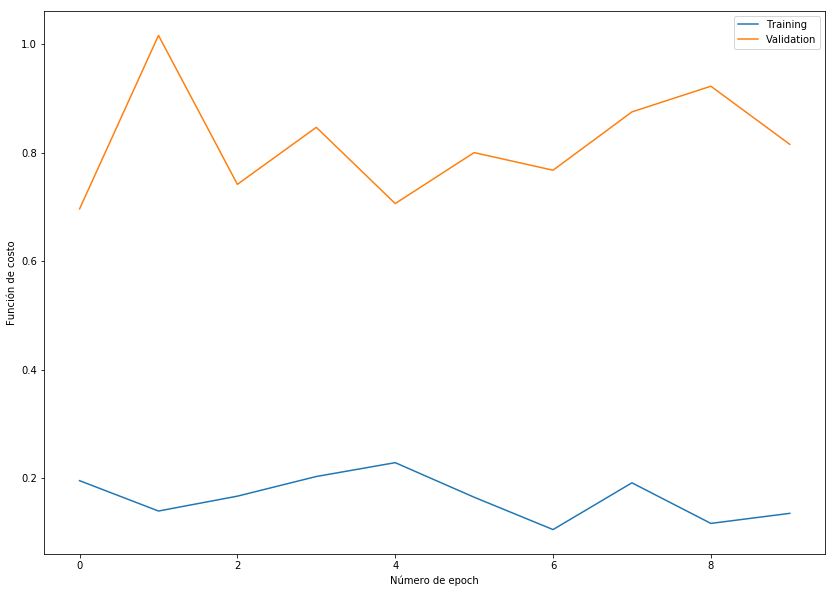

In [19]:
# Graficar la función de costo
plt.figure(figsize=(14,10))
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.xlabel("Número de epoch")
plt.ylabel("Función de costo")
plt.legend();

In [18]:
# Predicción de clases de un batch de prueba
model.predict_classes(x_batch)

array([2, 0, 0, 3, 3, 1, 4, 4, 0, 1, 0, 4, 1, 0, 0, 1, 4, 1, 1, 2, 1, 1,
       4, 4, 3, 4, 4, 0, 1, 0, 3, 1, 4, 4, 4, 2, 2, 0, 3, 0, 1])

In [19]:
# Evaluación del modelo con un conjunto de prueba
testLoss, testAcc = model.evaluate_generator(generator=validationGenerator)
print("Costo de prueba: ", testLoss)
print("Accuracy de prueba: ", testAcc)

Costo de prueba:  0.8213305473327637
Accuracy de prueba:  0.7560975551605225


## Graficamos algunas imágenes y sus predicciones

In [27]:
# Accedemos al diccionario de clases creado por el ImageDataGenerator
trainGenerator.class_indices

{'ant': 0, 'beaver': 1, 'lobster': 2, 'panda': 3, 'pigeon': 4}

In [26]:
# Obtenemos un diccionario inverso para las clases
inv_class_dict = {v: k for k, v in trainGenerator.class_indices.items()}
inv_class_dict

{0: 'ant', 1: 'beaver', 2: 'lobster', 3: 'panda', 4: 'pigeon'}

In [40]:
def predictElement(x, label, model, inv_dict):
    # Obtener la predicción del elemento
    predicted_label = model.predict_classes(x.reshape(1, IMG_WIDTH, IMG_HEIGHT, -1))[0]
    
    # Obtener las etiquetas
    predicted_class = inv_dict[predicted_label]
    actual_class = inv_dict[label]
    
    # Graficar la imagen
    plt.imshow(x)
    plt.axis('off')
    plt.title("%s" % predicted_class)
    #plt.title("Clase: %s, Modelo: %s" % (actual_class, predicted_class))

In [41]:
def graficarElementos(X, labels, n, model, inv_dict, columns=5):
    # Obtener la muestra de ejemplos
    N = X.shape[0]
    rnd_idx = np.random.randint(0, N, n)
    x_batch = X[rnd_idx]
    labels_batch = labels[rnd_idx]
    
    # Graficar los elementos
    rows = np.ceil(n / columns).astype(np.int)
    plt.figure(figsize = (16,10))
    for i in range(n):
        plt.subplot(rows, columns, i+1)
        predictElement(x_batch[i], labels_batch[i], model, inv_dict)
        

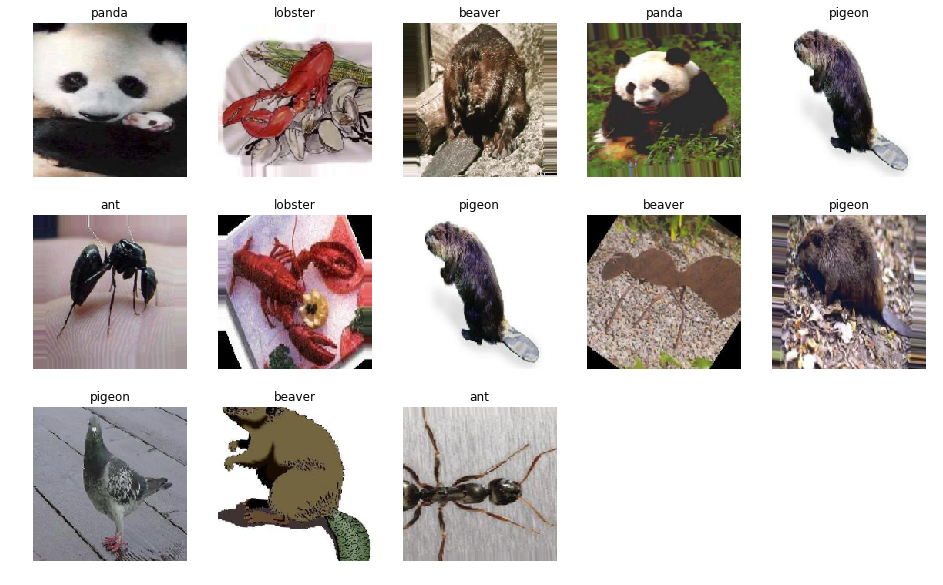

In [42]:
# Obtenemos etiquetas original del conjunto de prueba
labels = np.argmax(y_batch, axis=1)
graficarElementos(x_batch, np.argmax(y_batch, axis=1), 13, model, inv_class_dict)

## Visualización de las capas convolucionales


In [14]:
# Obtener los pesos de la primera capa convolucional
conv2d_weights, conv2d_biases = model.layers[0].get_weights()
conv2d_weights.shape

(3, 3, 3, 32)

Como vemos, las dimensiones de esta capa corresponden a la de 32 filtros de 3x3, cada uno en 3 canales. Están distribuidos de la forma `(ancho, alto, canal, filtro)`

In [15]:
conv2d_weights[:, :, 0, 0]

array([[-0.06171949, -0.09483739,  0.01593766],
       [ 0.01462306, -0.0151868 ,  0.02125671],
       [ 0.10582294,  0.12332737,  0.00058783]], dtype=float32)

In [24]:
conv2d_weights[:, :, 1, 0]*255

array([[-30.940573, -14.306736, -33.896458],
       [-23.177422, -25.875973,  25.718306],
       [ 23.249546,   7.760158,  14.121878]], dtype=float32)

In [26]:
np.min(conv2d_weights[:, :, :, 0])

-0.13292728

In [27]:
np.max(conv2d_weights[:, :, :, 0])

0.16290681

# Conclusiones

En este ejercicio se ajusta un modelo de redes neuronales convolucionales para la clasificación de imágenes de animales de 5 tipos diferentes. Como se observa en la figura anterior, el modelo logra clasificar adecuadamente la mayoría de las imágenes, logrando una precisión del 75%. En este caso, en pruebas anteriores se obtuvo una precisión de hasta el 85% sobre un conjunto de prueba. Sin embargo, en la etapa de pruebas el entrenamiento se reinició y debido al alto costo de entrenamiento, en términos de tiempo, se decidió dejar este modelo como la versión final. Posteriormente, se implementó el proceso de *checkpointing* para guardar el estado del entrenamiento.

Se puede concluir que en el entrenamiento de redes neuronales convolucionales es importante la utilización de *checkpoints* para guardar el estado del entrenamiento en todo momento, ya que el proceso computacionalmente costoso. Finalmente, aunque el experimento de clasificación se puede considerar como exitoso, es posible variar un poco la arquitectura para mejorar la precisión del modelo en la clasificación de los diferentes tipos de animales, pero esto requeriría un nuevo proceso de entrenamiento y más tiempo de pruebas.